# Logistic Regression with the Titanic

### Due 03/07/2016
### By Jacob Metzger

Goal: Create a logistic regression model to predict survival on the Titanic.
* The model will be validated against a random 20% holdout using the train_test_split function.

In [94]:
from __future__ import division #for floating division
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
%matplotlib inline
np.random.seed(314) # Set for reproducibility. 

In [95]:
# The following is clipped from the Random Forests == Awesome notebook in the course notes

# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [96]:
#Another function taken from the Random Forests == Awesome notebook from the course page

# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))

### Data processing functions/options

In [97]:
#Handle PassengerId
def handlePassengerId(X):
    return X #don't do anything

def dropPassengerId(X):
    return X.drop(["PassengerId"], axis=1) #Drop the PassengerId at the onset -- any value this variable has is elusive

In [98]:
#Handle Ticket
def handleTicket(X): #Handles ticket by splitting the ticket number and ticket prefix, providing the number and a boolean variable instead
    ticketsSplit = [_.split(" ") for _ in X.Ticket] #split the ticket codes into prefix and number
    ticketNumbers = [int(_[-1]) if _[-1]!='LINE' else 0 for _ in ticketsSplit] 
    ticketNumbersTransform = np.log(np.array(ticketNumbers)+1)
    hasTicketPrefix = [1 if _.__len__()>1 else 0 for _ in ticketsSplit] 
    X = pd.concat([X, pd.DataFrame(ticketNumbersTransform, columns=['TicketNumTrans']), pd.DataFrame(hasTicketPrefix, columns=["HasTicketPrefix"])], axis=1)
    X=X.drop(["Ticket"], axis=1)
    return X

def dropTicket(X):
    return X.drop(["Ticket"], axis=1)

In [99]:
#Handle Name
def handleName(X): #Handles Name by taking the prefix, correcting for some odd values, and providing dummy variables
    prefixes = [name.split(",")[1].split(" ")[1] for name in X.Name]
    for i, item in enumerate(prefixes):
        if prefixes[i] in ["Mr.", "Miss.", "Mrs.", "Master."]:
            #do nothing
            pass
        elif prefixes[i] in ["Mlle."]:
            prefixes[i]="Miss."
        elif prefixes[i] in ["Ms.", "Mme."]:
            prefixes[i]="Mrs."
        elif prefixes[i] in ["Jonkheer.", "Sir.", "Don."]:
            prefixes[i] = "Nobility"
        elif prefixes[i] in ["Lady.", "the"]: #"the" is for the countess
            prefixes[i] = "Nobility"
        elif prefixes[i] in ["Col.", "Major.", "Capt."]:
            prefixes[i]="CrewMember"
        elif prefixes[i] in ["Dr.", "Rev."]:
            prefixes[i]="CrewMember"
        else:
            print item # There should be no output if all prefixes are handled correctly!
    X = pd.concat([X, pd.get_dummies(prefixes)], axis=1)
    X = X.drop(["Name", "Mr."], axis=1)
    return X

def dropName(X):
    return X.drop(["Name"], axis=1)

In [100]:
#Handle SibSp
def handleSibSp(X): #Handles SibSp with a mathematical transform
    X = pd.concat([X, pd.DataFrame([np.exp(-1/(x+1)**2) for x in X.SibSp], columns=["SibSpTransform"])], axis=1)
    X = X.drop(['SibSp'], axis=1)
    return X

def dropSibSp(X):
    return X.drop(["SibSp"], axis=1)

In [101]:
#Handle Parch
def handleParch(X): #Handles Parch with a mathematical transform
    X = pd.concat([X, pd.DataFrame([np.exp(-1/(x+1)**2) for x in X.Parch], columns=["ParchTransform"])], axis=1)
    X = X.drop(['Parch'], axis=1)
    return X

def dropParch(X):
    return X.drop(['Parch'], axis=1)

In [102]:
#Handle Cabin
def handleCabin(X): #Handles cabin by providing both a cabin count (imputing a mean, when necessary) and the cabin letter
    cabinSplit = [str(_).split(" ") for _ in X.Cabin] #tokenize the cabins
    cabinsFinalSplit = [[cabin if cabin=="nan" else [cabin[0],cabin[1:]] for cabin in cabins] for cabins in cabinSplit] 

    numCabins = [0 if _[0]=="nan" else _.__len__() for _ in cabinsFinalSplit ]
    X = pd.concat([X, pd.DataFrame(numCabins, columns=["NumCabins"])], axis=1)
    X.NumCabins=X.NumCabins.replace(0, X.NumCabins.mean())

    cabinLetters = ["None" if cabin[0]=="nan" else cabin[0][0] for cabin in cabinsFinalSplit]
    X=pd.concat([X, pd.get_dummies(pd.DataFrame(cabinLetters, columns=["CabinLetters"]))], axis=1)
    X=X.drop(["Cabin", "CabinLetters_B"], axis=1)
    
    return X

def dropCabin(X):
    return X.drop(["Cabin"], axis=1)

In [103]:
#Handle PClass
def handlePclass(X): #Provides dummy variables for Pclass
    X = pd.concat([X, pd.get_dummies(X.Pclass)], axis=1)
    X = X.drop(["Pclass", 3], axis=1)
    return X

def dropPclass(X):
    return X.drop(["Pclass"], axis=1)

In [104]:
#Handle Sex
def handleSex(X): #Provides dummy variables for Sex
    X.Sex = pd.get_dummies(X.Sex).female #Just replace the Sex column altogether
    return X

def dropSex(X):
    return X.drop(["Sex"], axis=1)

In [105]:
#Handle Embarked
def handleEmbarked(X): #Provides dummy variables for Embarked after imputing missing values with the mode
    X.Embarked = X.Embarked.fillna(X.Embarked.mode())
    X = pd.concat([X, pd.get_dummies(X.Embarked)], axis=1)
    X = X.drop(["Embarked", "C"], axis=1)
    return X

def dropEmbarked(X):
    return X.drop(["Embarked"], axis=1)

In [106]:
#Handle Fare
def handleFare(X): #Handles Fare by imputing the mean into N/A and 0 values
    originalFare = X.Fare
    X.Fare = X.Fare.fillna(originalFare.mean())
    X.Fare = X.Fare.replace(0, originalFare.mean()) #It seems odd to have zero fares... Probably outliers anyway, so impute them.
    return X
    
def binFare(X): #Handles Fare by binning it into a set of bins
    numFareBins = 10
    fareBins = pd.cut(X.Fare, numFareBins, labels=[str(_)+"Fare" for _ in range(0, numFareBins, 1)])
    X = pd.concat([X, pd.get_dummies(fareBins)], axis=1)
    X = X.drop(["Fare", "0Fare"], axis=1)
    return X
    
def logFare(X): #Handles Fare with a log transform
    X.Fare = np.log(X.Fare+1)
    return X
    
def dropFare(X):
    return X.drop(["Fare"], axis=1)

In [107]:
#Handle Age
def handleAge(X): #Fills missing values of Age with the predictions of a Random Forest regression on the other variables
    ageDataset=X.dropna(axis=0)
    ageTarget = pd.DataFrame(ageDataset.Age)
    ageDataset = ageDataset.drop(["Age"], axis=1)

    import numpy
    datasetMissingAgeVals = X[numpy.isnan(X.Age)]
    datasetMissingAgeVals = datasetMissingAgeVals.drop(["Age"], axis=1)

    from sklearn.ensemble import RandomForestRegressor
    ageClassifier= RandomForestRegressor(n_estimators=1000, random_state=314)
    ageClassifier.fit(ageDataset, ageTarget.astype(int))
    guessedAges = ageClassifier.predict(datasetMissingAgeVals)

    counter=0
    for row in xrange(0,len(X.Age)):
        if numpy.isnan(X.Age[row]):
            X.Age[row]=guessedAges[counter]
            counter+=1
    return X

def dropAge(X):
    return X.drop(["Age"], axis=1)

def binAge(X): #Handles Age by first getting the values filled then binning into categories Child, Adult, and Elderly
    X = handleAge(X)
    from collections import defaultdict
    triBins = defaultdict(str)
    for i in xrange(len(X.Age)):
        if X.Age.iloc[i]<16:
            triBins[i]="Child"
        elif X.Age.iloc[i]<55:
            triBins[i]="Adult"
        else:
            triBins[i]="Elderly"
    X = pd.concat([X, pd.get_dummies(triBins)], axis=1)
    X = X.drop(["Child"], axis=1)
    X = X.drop(["Age"], axis=1)
    return X

def meanAge(X): #Imputes missing values of Age with the mean
    X.Age = X.Age.fillna(X.Age.mean())
    return X

## Begin Work

In [108]:
titanicDataset = pd.read_csv("train.csv")
X = titanicDataset.drop(["Survived"], axis=1)
y = titanicDataset.Survived

In [109]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [110]:
describe_categorical(X) 

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [111]:
#Process data here
#The variables presented to the model are altered by the processing done here.

X = dropPassengerId(X)

#X = handlePclass(X)
X = dropPclass(X)

X = handleName(X)
#X = dropName(X)

X = handleSex(X)
#X = dropSex(X)

#X = handleSibSp(X)
#X = dropSibSp(X)

#X = handleParch(X)
#X = dropParch(X)

#X = handleTicket(X)
X = dropTicket(X)

#X = handleFare(X)
#X = binFare(X)
X = logFare(X)
#X = dropFare(X)

X = handleCabin(X)
#X = dropCabin(X)

X = handleEmbarked(X)
#X = dropEmbarked(X)

#X = handleAge(X)  # Do this last because of the way we're imputing Age
X = binAge(X)
#X = meanAge(X)
#X = dropAge(X)

C:\Users\Izzy\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Izzy\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [112]:
X.describe()

,Sex,SibSp,Parch,Fare,CrewMember,Master.,Miss.,Mrs.,Nobility,NumCabins,...,CabinLetters_D,CabinLetters_E,CabinLetters_F,CabinLetters_G,CabinLetters_None,CabinLetters_T,Q,S,Adult,Elderly
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.352413,0.523008,0.381594,2.962246,0.020202,0.044893,0.206510,0.142536,0.005612,0.473073,...,0.037037,0.035915,0.014590,0.004489,0.771044,0.001122,0.086420,0.722783,0.847363,0.048260
std,0.477990,1.102743,0.806057,0.969048,0.140770,0.207186,0.405028,0.349796,0.074743,0.449236,...,0.188959,0.186182,0.119973,0.066890,0.420397,0.033501,0.281141,0.447876,0.359840,0.214436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.187218,0.000000,0.000000,0.000000,0.000000,0.000000,0.267116,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,2.737881,0.000000,0.000000,0.000000,0.000000,0.000000,0.267116,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,0.000000,3.465736,0.000000,0.000000,0.000000,0.000000,0.000000,0.267116,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,8.000000,6.000000,6.240917,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
#Scale the set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [114]:
# Make train and test datasets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [115]:
#ROC point estimate
from sklearn.linear_model import LogisticRegression
logisticModel = LogisticRegression(C=1)
logisticModel.fit(X_train,y_train)
print "ROC: ", roc_auc_score(y_test, logisticModel.predict(X_test))

ROC:  0.833564879133


In [116]:
#Adapted directly from Week 6 lecture notebook
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logisticModel.predict_proba(X_test)[:,1])
%pylab inline

Populating the interactive namespace from numpy and matplotlib


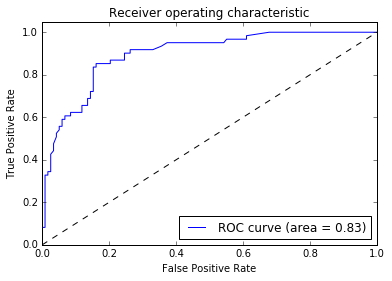

In [118]:
#Adapted directly from Week 6 lecture notebook
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, logisticModel.predict(X_test)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()